## Trabajo Práctico: Red Neuronal Lineal.

aca hay que poner una introducción supongo idk



Nota: aca en el notebook usamos algunas funciones como @, qr, de NP solo para probar y comparar con
los resultados correctos. Las soluciones a todos los sistemas verdaderos y las implmentaciones de 
todas las funciones nuestras implementan cada una de estas operaciones a mano. 

In [13]:
import numpy as np
import sys
import matplotlib.pyplot as plt
import pandas as pd

from alc import *
# TODO esto todo va a estar en alc cuando terminemos y hay que borrarlo
sys.path.append(".")
sys.path.append("./src")
sys.path.append("../src")
from labo00_auxiliares import *
from labo01_errores_igualdad import *
from labo02_TLs_basicas import *
from labo03_normas import *
from labo04_LU import *
from labo05_QR import *
from labo06_AVs import *
from labo07_markov import *
from labo08_SVD import *
import os


np.set_printoptions(precision=3, linewidth=150, suppress=True)

os.getcwd()[-3:]



'/TP'

no se explicar que hacemos las pruebas

Recordamos, los "t" son los valores de entrenamiento, y los v son los de testeo

In [14]:
#Xt, Yt, Xv, Yv = cargarDataset("cats_and_dogs") 
Xt, Yt, Xv, Yv =  cargarDatasetReducido("cats_and_dogs", 5, 4)
#print(Xt)
print(Xt.shape)
#print(Xv)
print(Xv.shape)
print(Yt, Yt.shape)
print(Yv, Yv.shape)

(5, 8)
(5, 8)
[[0 0 0 0 1 1 1 1]
 [1 1 1 1 0 0 0 0]] (2, 8)
[[0 0 0 0 1 1 1 1]
 [1 1 1 1 0 0 0 0]] (2, 8)


### QR
voy a intentar que funcione con QR que es la única que creo que ya esta implementada. 

problema: solo funciona sobre matrices cuadradas, hay que cambiar eso
problema: muy lento. vamos a cachearlo una vez calculado en un archivo para no tener que volver a hacerlo mientras testeamos cosas


In [15]:
cache_save_enabled = False

def cache(calc, name):
    if cache_save_enabled and os.path.isfile(f"{name}.npy"):
        return np.load(f"{name}.npy")
    else:
        val = calc()
        if cache_save_enabled:
            np.save(f"{name}.npy", val)
        return val

def cache_many(calc, names):
    if cache_save_enabled and all([os.path.isfile(f"{name}.npy") for name in names]):
        return tuple([cache(lambda:None, name) for name in names])
    else:
        vals = calc()
        for name, val in zip(names, vals):
            cache(lambda:val, name)
        return vals
    
    

#### Por Gram shmidt

In [16]:
Q, R = cache_many(lambda: QR_con_GS(traspuesta(Xt)), ["QGS", "RGS"])

assert np.allclose(Q @ R, traspuesta(Xt)) # lo hago con @ solo aca para probar

WGS = cache(lambda:pinvGramSchmidt(Q,R,Yt), "WGS")


listo resolviendo sistema
listo trasponiendo
Calculando W


In [17]:
YvEsperadosGS = cache(lambda:matmul(WGS, Xv), "YvEsperadosGS")
print(YvEsperadosGS)
print(Yv)

## comparemos con funcion numpy por si a caso
QNP,RNP = np.linalg.qr(traspuesta(Xt))
YvEsperadosNPQR = pinvGramSchmidt(QNP,RNP,Yt) @ Xv
assert np.allclose(YvEsperadosGS,  YvEsperadosNPQR)




[[ 0.193  1.763 -0.149  0.553  1.503 -0.004  1.242  0.212]
 [ 1.096  2.449  0.189  0.269  0.764 -0.011  1.312  0.882]]
[[0 0 0 0 1 1 1 1]
 [1 1 1 1 0 0 0 0]]
listo resolviendo sistema
listo trasponiendo
Calculando W


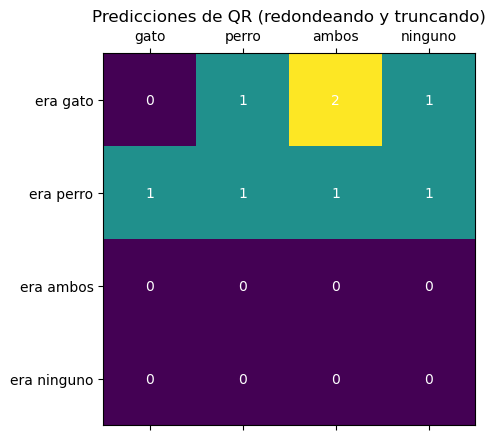

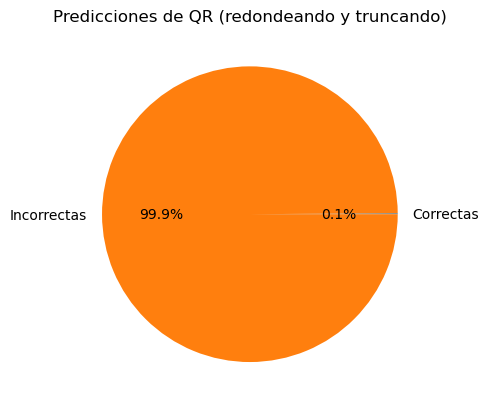

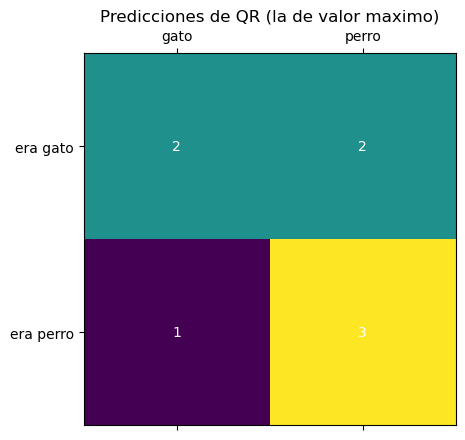

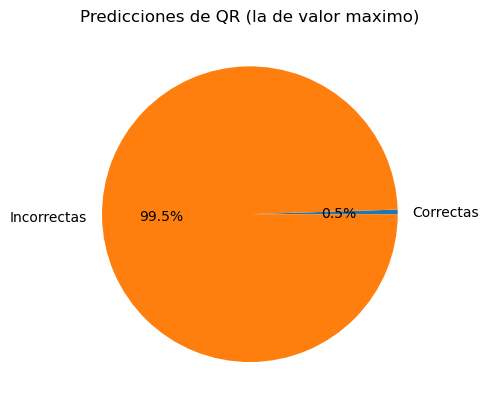

In [18]:
# medio feo tener un choclo de codigo aca pero peor era tener que importar matplotlib en ALC.py  
def graficar_predicciones_de_metodo(nombre_metodo, predicciones, valores_reales):
    gato = [1,0]
    perro = [0,1]
    gato_y_Perro = [1, 1]
    ni_gato_ni_Perro = [0, 0]

    posibilidades = [gato, perro, gato_y_Perro, ni_gato_ni_Perro]
    posibilidadesNombres = ["gato", "perro", "ambos", "ninguno"]
    confusion = np.zeros((4,4))
    
    for prediccion, valorCorrecto in zip(  np.round(np.clip(traspuesta(predicciones), 0, 1)) , np.round(traspuesta(valores_reales)) ):
        indiceY = posibilidades.index(list([int(x) for x in valorCorrecto]))
        indiceX = posibilidades.index(list([int(x) for x in prediccion]))
        confusion[ indiceY ][ indiceX ] += 1


    
    plt.matshow(confusion)
    plt.title(f"Predicciones de {nombre_metodo} (redondeando y truncando)")
    plt.xticks(range(len(posibilidadesNombres)), posibilidadesNombres)
    plt.yticks(range(len(posibilidadesNombres)), ["era "+n for n in posibilidadesNombres ])
    
    for i ,row in enumerate(confusion):
        for j ,val in enumerate(row):
            plt.text(j, i, f"{int(val)}", ha="center", va="center", color="white" if val < 50 else "black") 

    plt.show()
    
    pie(confusion,nombre_metodo + " (redondeando y truncando)")


    posibilidadesNombres = ["gato", "perro"]
    confusion2 = np.zeros((2,2))
    for prediccion, valorCorrecto in zip(  traspuesta(predicciones) , traspuesta(valores_reales) ):
        indiceY = int(1-valorCorrecto[0])
        indiceX = int(max(prediccion) == prediccion[1])
        confusion2[ indiceY ][ indiceX ] += 1
    
    plt.matshow(confusion2)
    plt.title(f"Predicciones de {nombre_metodo} (la de valor maximo)")
    plt.xticks(range(len(posibilidadesNombres)), posibilidadesNombres)
    plt.yticks(range(len(posibilidadesNombres)), ["era "+n for n in posibilidadesNombres ])
    
    for i ,row in enumerate(confusion2):
        for j ,val in enumerate(row):
            plt.text(j, i, f"{int(val)}", ha="center", va="center", color="white" if val < 200 else "black") 
    plt.show()
    pie(confusion2, nombre_metodo + " (la de valor maximo)")


def pie(confusion, nombre_metodo):
    correcto = 0
    incorrecto = 0
    for i in range(len(confusion)):
        correcto += confusion[i][i]

    incorrecto = 1000 - correcto
    plt.pie([correcto, incorrecto], labels=["Correctas", "Incorrectas"], autopct='%1.1f%%')
    plt.title(f"Predicciones de {nombre_metodo}")
    plt.show()

graficar_predicciones_de_metodo("QR", YvEsperadosGS, Yv)

#### Por HH

In [19]:
QHH, RHH = cache_many(lambda: QR_con_HH(traspuesta(Xt)), ["QHH", "RHH"])

assert np.allclose(QHH @ RHH, traspuesta(Xt)) # lo hago con @ solo aca para probar mas rapido

In [20]:

WHH = cache(lambda:pinvHouseHolder(QHH,RHH,Yt), "WHH")
assert np.allclose(WHH, WGS)

print(f"W: {np.round(WHH,3).shape}")
YvEsperadosHH = cache(lambda:matmul(WHH, Xv), "YvEsperadosHH")
print(YvEsperadosHH)
print(Yv)
assert np.allclose(YvEsperadosHH, YvEsperadosGS)





listo resolviendo sistema
listo trasponiendo
Calculando W
W: (2, 5)
[[ 0.193  1.763 -0.149  0.553  1.503 -0.004  1.242  0.212]
 [ 1.096  2.449  0.189  0.269  0.764 -0.011  1.312  0.882]]
[[0 0 0 0 1 1 1 1]
 [1 1 1 1 0 0 0 0]]


### SVD

In [21]:
U,S,V = cache_many(lambda: svd_reducida(Xt), ["U","S","V"])
assert np.allclose(U @ np.diag(S) @ traspuesta(V), Xt)

WSVD = cache(lambda:pinvSVD(U,S,V,Yt), "WSVD")


In [22]:


print(f"W: {np.round(WSVD,3).shape}")
YvEsperadosSVD = cache(lambda:matmul(WSVD, Xv), "YvEsperadosSVD")

print(YvEsperadosSVD)
print(Yv)


UNP,SNP,VNP = np.linalg.svd(Xt)
VNP = VNP.T[:,:Xt.shape[0]]
assert np.allclose(UNP @ np.diag(SNP) @ traspuesta(VNP), Xt)

WSVDNP = pinvSVD(UNP,SNP,VNP,Yt)
YvEsperadosSVDNP = WSVDNP @ Xv

assert np.allclose(YvEsperadosSVD, YvEsperadosSVDNP)


W: (2, 5)
[[ 0.193  1.763 -0.149  0.553  1.503 -0.004  1.242  0.212]
 [ 1.096  2.449  0.189  0.269  0.764 -0.011  1.312  0.882]]
[[0 0 0 0 1 1 1 1]
 [1 1 1 1 0 0 0 0]]


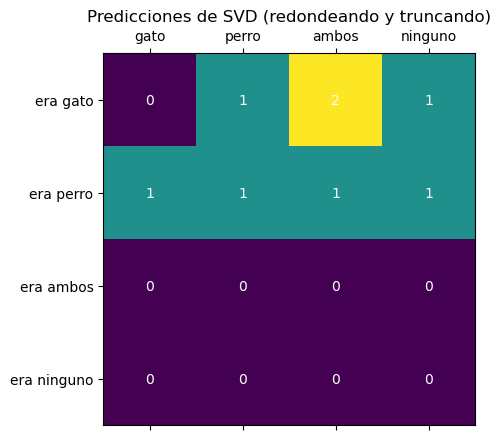

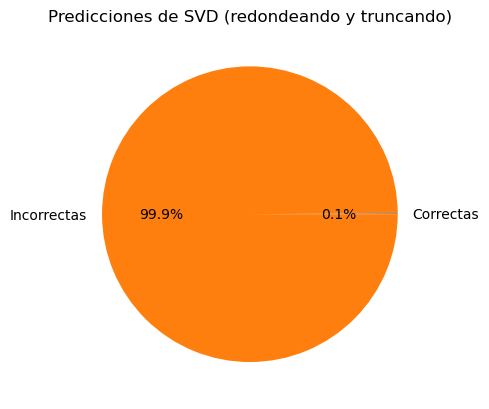

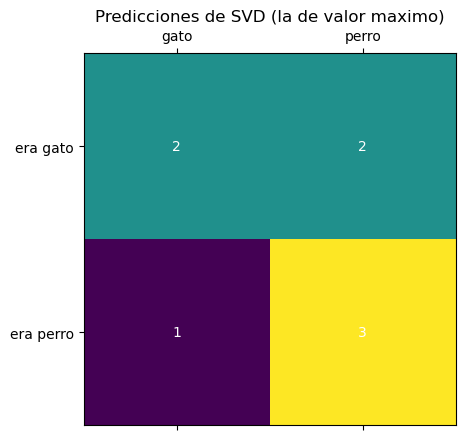

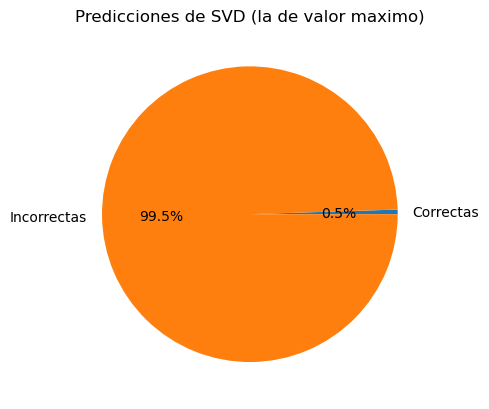

In [23]:
graficar_predicciones_de_metodo("SVD", YvEsperadosSVD, Yv)

### Cholesky / Ecuaciones Normales

In [24]:
LCholesky = cache(lambda: cholesky(matmul(Xt, traspuesta(Xt))), "LCholesky")
assert np.allclose(LCholesky @ traspuesta(LCholesky), matmul(Xt, traspuesta(Xt)))

WEqNorm = cache(lambda:pinvEcuacionesNormales(Xt,LCholesky,Yt), "WEN")



In [26]:

print(f"W: {np.round(WEqNorm,3).shape}")
YvEsperadosEqNorm = cache(lambda:matmul(WEqNorm, Xv), "YvEsperadosEqNorm")

print(YvEsperadosEqNorm)
print(Yv)


LCholeskyNP = np.linalg.cholesky(Xt @ Xt.T)

WWEqNormNP = pinvEcuacionesNormales(Xt, LCholeskyNP, Yt)
YvEsperadosEqNormNP = WWEqNormNP @ Xv

assert np.allclose(YvEsperadosEqNormNP, YvEsperadosEqNorm)


W: (2, 5)
[[ 0.193  1.763 -0.149  0.553  1.503 -0.004  1.242  0.212]
 [ 1.096  2.449  0.189  0.269  0.764 -0.011  1.312  0.882]]
[[0 0 0 0 1 1 1 1]
 [1 1 1 1 0 0 0 0]]


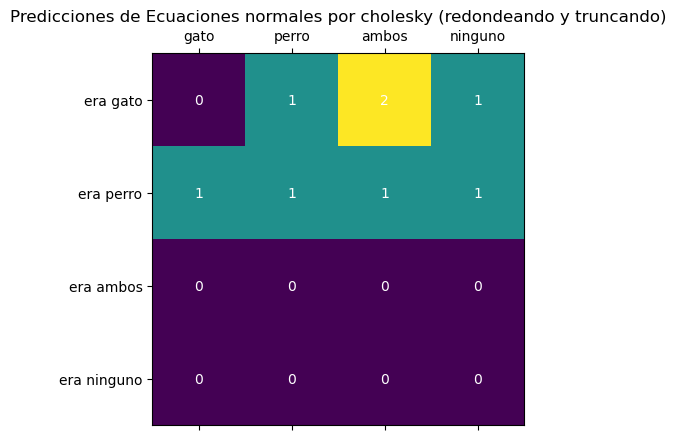

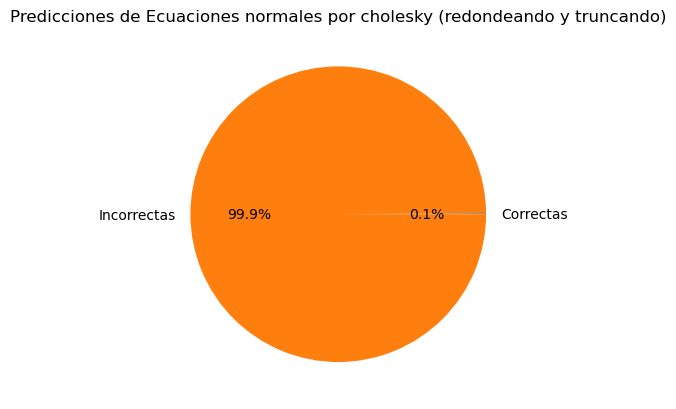

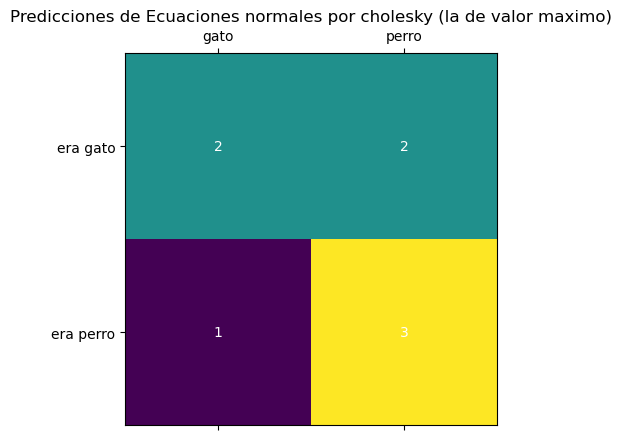

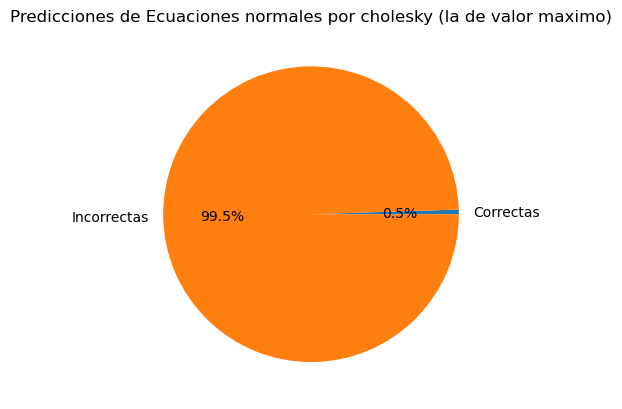

In [27]:
graficar_predicciones_de_metodo("Ecuaciones normales por cholesky", YvEsperadosEqNorm, Yv)